<a href="https://colab.research.google.com/github/gladysbabs/Prediction-of-Product-Sales/blob/main/Project_1_SalesPrediction_Part_5_(Core)_Gladys_Babirye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [75]:
df=pd.read_csv("/content/drive/MyDrive/CodingDojo/02-IntroML/Week05/Data/sales_predictions_2023.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
#checking data types
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

- The data types are as expected as per the data dictionary.

In [5]:
#Checking for duplicates
df.duplicated().sum()

0

- No duplicates

In [6]:
#Checking for inconsistencies
cat_cols=df.select_dtypes(object)
#
for cols in cat_cols:
  print(f"The value count for {cols}")
  print(df[cols].value_counts())
  print('\n')

The value count for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


The value count for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


The value count for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


The value count for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OU

In [76]:
#Addressing the inconsistency in 'Item_Fat_Content': LF:Low_Fat,reg:Regular,low fat:Low Fat

df['Item_Fat_Content']=df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})

In [8]:
#checking for missing values:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Missing values need to be addressed.
 - Using EDA functions to zero down on how to analyze the missing values.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

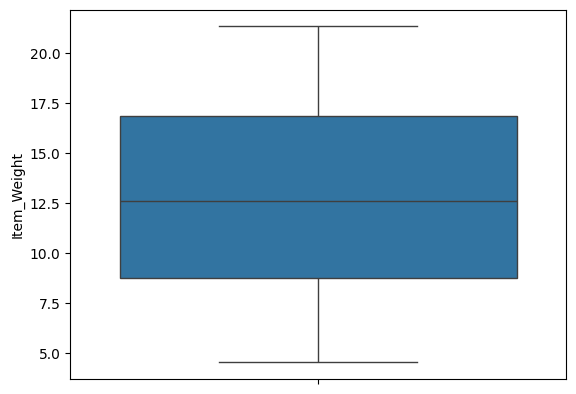

In [10]:
#Using a boxplot to find out which imputer to use for the numeric_column: 'Item_Weight'
ax=sns.boxplot(df,y='Item_Weight')

- There is no skewness or any outliers in the boxplot. Therefore whether I use the median or mean as an imputer, the results will still be the same.
   - Therefore I'll go ahead and use the median imputer for the numeric column 'Item_Weight'

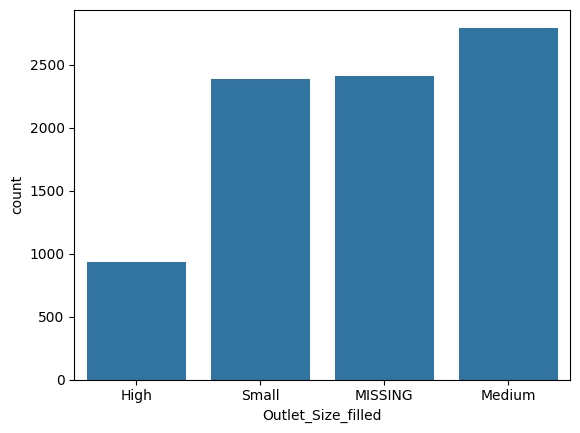

In [11]:
#Using a countplot to find out which imputer to use for the categorical column: 'Outlet_Size'
order_outlet=['High','Small','MISSING','Medium']

df['Outlet_Size_filled'] = df['Outlet_Size'].fillna('MISSING')
ax=sns.countplot(df,x='Outlet_Size_filled',order=order_outlet)

In [12]:
df['Outlet_Size'].value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

- Indeed the null values are quite significant and we shall address them by filling them with the 'most_frequent' value.

## Declaring (X) features and the (y) target.

In [77]:
y=df['Item_Outlet_Sales']
features=df.drop(columns=['Item_Outlet_Sales'])
#Dropping the column 'Item_Identifier' as well because it has a very high cardinality.
X=features.drop(columns=['Item_Identifier'])

In [61]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler


In [78]:
#Train_test_Split
X_train,X_test,y_train,y_test=train_test_split(X,y)

## Pipelines

In [63]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [79]:
num_cols=X_train.select_dtypes('number').columns
ord_cols=['Item_Fat_Content','Outlet_Size','Outlet_Location_Type']
cat_cols=X_train.select_dtypes('object').drop(columns=ord_cols).columns

In [80]:
#Pipeline for numerical data using the imputer strategy as median
imputer_median=SimpleImputer(strategy='median')
scaler=StandardScaler()
num_pipeline=make_pipeline(imputer_median,scaler)

In [81]:
#Pipeline for ordinal data
imputer_mos=SimpleImputer(strategy='most_frequent')
#The different categories' orders:
fat_ord=['Regular','Low Fat']
out_size_ord=['Small','Medium','High']
out_loc_ord=['Tier 1','Tier 2','Tier 3']
ordinal_category_orders=[fat_ord,out_size_ord,out_loc_ord]
#Ordinal encoder
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
#Scaling ordinal features
ord_scale=StandardScaler()
#The pipeline
ord_pipeline=make_pipeline(imputer_mos,ord_encoder,ord_scale)


In [83]:
#pipeline for categorical data:
impute_na=SimpleImputer(strategy='constant',fill_value='MISSING')
#OneHotEncoding
ohe_cat=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
#cat_pipeline
cat_pipeline=make_pipeline(impute_na,ohe_cat)

##The preprocessor

In [84]:
cat_tuple=('categorical',cat_pipeline,cat_cols)

num_tuple=('numeric',num_pipeline,num_cols)

ord_tuple=('ordinal',ord_pipeline,ord_cols)

col_transformer=ColumnTransformer([cat_tuple,num_tuple,ord_tuple],verbose_feature_names_out=False)


In [85]:
#Fitting the column transformer on the X_train data:
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strat...
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Regular',
                                                                              'Low '
                                                                              'Fat'],
                                                                             ['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Item_Fat_Content', 'Outlet_Size',
                                  'Outlet_Location_Type'])],
                  verbose_feature_names_out=False)

In [86]:
#Transforming the X_train data:
X_train_processed=col_transformer.transform(X_train)
#Transforming the X_test data:
X_test_processed=col_transformer.transform(X_test)

In [87]:
#confirming that all columns are numeric dtypes:
X_train_processed.dtypes

Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Identifier_OUT010           float64
Outlet_Identifier_OUT013           float64
Outlet_Identifier_OUT017           float64
Outlet_Identifier_OUT018           float64
Outlet_Identifier_OUT019           float64
Outlet_Identifier_OUT027           float64
Outlet_Identifier_OUT035           float64
Outlet_Iden

In [90]:
#Confirming that the transformed numeric features have been scaled:
X_train_processed[num_cols].describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,6392.00,6392.00,6392.00,6392.00
mean,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00
min,-1.94,-1.28,-1.75,-1.53
25%,-0.82,-0.76,-0.76,-1.29
50%,-0.05,-0.24,0.02,0.13
75%,0.77,0.56,0.72,0.73
max,2.01,5.08,2.01,1.32


- As can be seen, the transformed numeric features have been scaled since the mean is approximately 0 and the standard deviation is approximately 1.